In [9]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Read data from excel

In [1]:
retail_data=pd.read_excel('./Desktop/Lab2/online_retail.xlsx')

# Data manipulation

In [10]:
#drop duplicate rows

retail_data=retail_data.drop_duplicates()

In [11]:
#Remove all cancellations

retail_c=retail_data[retail_data['Invoice'].str[0]!='C']

In [12]:
#rename column 

retail_c.columns=['invoice','stockcode','description','quantity','invoicedate','unitprice','customerid','country']

In [13]:
#changing the datatype to numeric

cols=['invoice','stockcode','quantity','unitprice','customerid']
retail_c[cols]=retail_c[cols].apply(pd.to_numeric,errors='coerce')

In [14]:
#drop rows where stockcode,description is missing 

retail_c1=retail_c.dropna(subset=['stockcode'] ,how='all')
retail_c2=retail_c1.dropna(subset=['description'] ,how='all')
retail_c2=retail_c1.dropna(subset=['customerid'] ,how='all')

In [15]:
# remove spaces from description field

retail_c2['description']=retail_c2['description'].str.strip()


# Data Analysis

Text(0.5, 1.0, 'Top 5 countries')

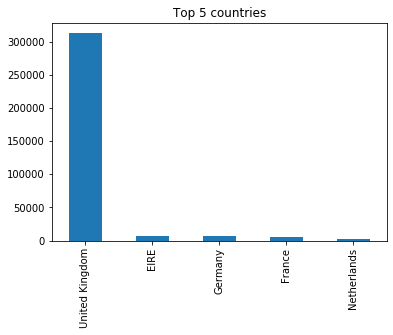

In [16]:
#top 5 countries

retail_c2.country.value_counts()[:5].plot.bar()
plt.title("Top 5 countries")

In [17]:
#removing countries except UK
retail_uk=retail_c2[retail_c2['country']=="United Kingdom"]

In [18]:
#removing negative quantity(items returned)
retail_uk=retail_uk[retail_uk['quantity']>0]

In [19]:
#removing free items
retail_uk=retail_uk[retail_uk['unitprice']>0]

In [20]:
# calculating total
retail_uk['total']=retail_uk.fillna(0)['quantity']*retail_uk.fillna(0)['unitprice']

In [21]:
#year column
retail_uk['year']=retail_uk['invoicedate'].dt.year

In [22]:
#month-year column

retail_uk['month_year']=pd.to_datetime(retail_uk['invoicedate']).dt.to_period('M')
#retail_uk['month_year']=retail_uk['invoicedate'].map(lambda date: 100*date.year + date.month)


Text(0.5, 1.0, 'Sales by Month')

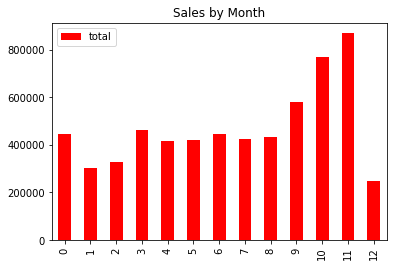

In [24]:
#total sales per month

ax =retail_uk.groupby('month_year')['total'].sum().reset_index().plot.bar(color='r',use_index='True')
plt.title("Sales by Month")
#ax.set_xticklabels(retail_uk.month_year)




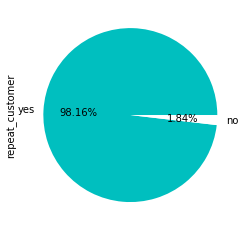

In [25]:
# One time and repeat customer

customer_invoice=retail_uk.groupby('customerid',as_index=False).agg({'invoice':'count'})
import numpy as np
customer_invoice['repeat_customer']=np.where(customer_invoice['invoice']>1,'yes','no')
import matplotlib.pyplot as plt
repeatcount=customer_invoice['repeat_customer'].value_counts()
repeatcount.plot.pie(autopct='%.2f%%',colors=['c','w'])
plt.show()

Text(0.5, 1.0, 'top 20 Products')

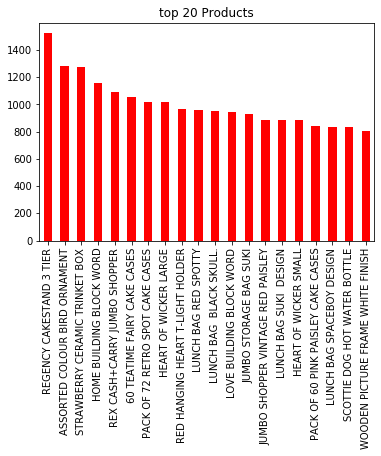

In [26]:
#top20 products

retail_uk.description.value_counts()[:20].plot(kind='bar',color='r')
plt.title("top 20 Products")

Text(0.5, 1.0, 'Top 20 Customers by Sales')

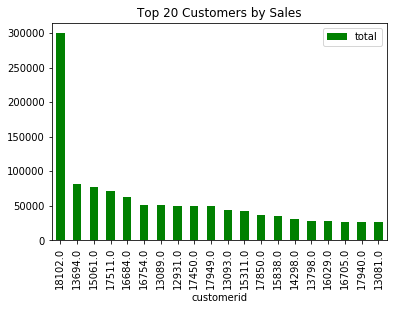

In [27]:

#top20 customers by sale amount
retail_top=retail_uk.groupby('customerid',as_index=False).agg({'total':'sum'})
retail_top20=retail_top.sort_values(by=['total'],ascending=False).head(20)
retail_top20['customerid']=retail_top20.customerid.astype(str)
retail_top20.plot.bar(x='customerid',y='total',color='g')
plt.title("Top 20 Customers by Sales")

Text(0.5, 1.0, 'Top 20 Customers by Orders')

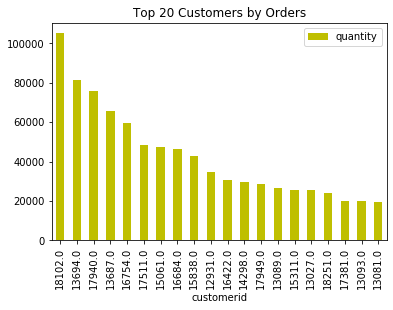

In [28]:
#top20 customer by order placed

retail_top=retail_uk.groupby('customerid',as_index=False).agg({'quantity':'sum'})
retail_top20=retail_top.sort_values(by=['quantity'],ascending=False).head(20)
retail_top20['customerid']=retail_top20.customerid.astype(str)
retail_top20.plot.bar(x='customerid',y='quantity',color='y')
plt.title("Top 20 Customers by Orders")



Text(0.5, 1.0, 'Average sales by month')

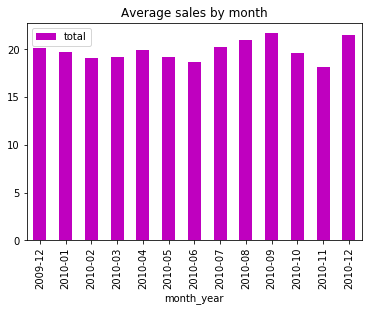

In [29]:
#average sales per month

retail_avg=retail_uk.groupby('month_year',as_index=False)['total'].mean()
retail_avg.plot.bar(x='month_year',y='total',color='m')
plt.title("Average sales by month")

Text(0.5, 1.0, 'Sales by Year')

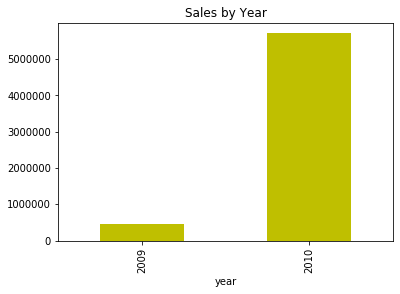

In [30]:
#total sales by year

retail_uk.groupby('year')['total'].sum().plot(kind='bar',color='y')
plt.title("Sales by Year")

Text(0.5, 1.0, 'Orders by Year')

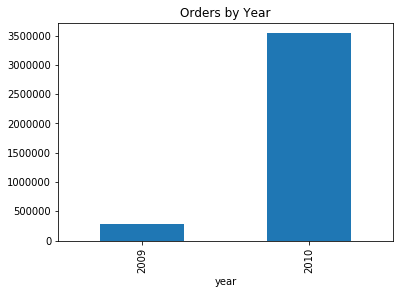

In [31]:
#total quantity by year
retail_uk.groupby('year')['quantity'].sum().plot(kind='bar')
plt.title("Orders by Year")

Text(0.5, 1.0, 'Customer by Month')

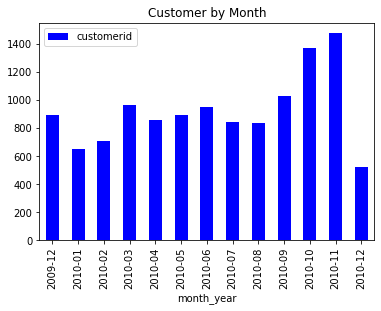

In [32]:
#active customers per month

active=retail_uk.groupby('month_year')['customerid'].nunique().reset_index()
active.plot.bar(x='month_year',y='customerid',color='b')
plt.title("Customer by Month")

# Data Partitioning

In [33]:
# Split the data into first 6 month and next 3 month

retail_uk['invoicedate'] = pd.to_datetime(retail_uk['invoicedate'])
retail_uk_6mon=retail_uk[(retail_uk['invoicedate']<'2010-9-01')& (retail_uk['invoicedate']>='2010-03-01')].reset_index(drop=True)
retail_uk_3mon=retail_uk[(retail_uk['invoicedate']>='2010-9-01')& (retail_uk['invoicedate']<'2010-12-01')].reset_index(drop=True)




# Features Dataset

In [34]:
retail_uk_customer=pd.DataFrame(retail_uk_6mon['customerid'].unique())
retail_uk_customer.columns=['customerid']

# Purchase Interval calculation 

In [35]:
#find the first purchase date in the 3 month list
retail_uk_first_3mon=retail_uk_3mon.groupby('customerid')['invoicedate'].min().reset_index()
retail_uk_first_3mon.columns=['customerid','firstpurchasedate']


#find the last purchase date in 6 month list
retail_uk_last_6mon=retail_uk_6mon.groupby('customerid')['invoicedate'].max().reset_index()
retail_uk_last_6mon.columns=['customerid','lastpurchasedate']


# new dataframe with purchase dates and interval
retail_uk_purchase=pd.merge(retail_uk_last_6mon,retail_uk_first_3mon,on='customerid')
retail_uk_purchase['purchaseinterval']=(retail_uk_purchase['firstpurchasedate']-retail_uk_purchase['lastpurchasedate']).dt.days

# add columns to user dataframe
retail_uk_customer=pd.merge(retail_uk_customer,retail_uk_purchase[['customerid','purchaseinterval']],on='customerid')

In [36]:
retail_uk_customer.head(5)

,customerid,purchaseinterval
0,16717.0,141
1,16202.0,118
2,13694.0,26
3,17241.0,66
4,14870.0,101


# Recency,Frequency and Monetary Value  Analysis(RFM)

### Recency

Recency is calculated by measuring the number of days between last purchase date by the customer and last purchase date in dataset

In [37]:
#Last Purchase date by the customer

retail_uk_lastpurchase=retail_uk_6mon.groupby('customerid').invoicedate.max().reset_index()
retail_uk_lastpurchase.columns=['customerid','lastpurchasedate']

#find the number of days between last purchase and last purchase in the dataset
retail_uk_lastpurchase['recency']=(retail_uk_lastpurchase['lastpurchasedate'].max()-retail_uk_lastpurchase['lastpurchasedate']).dt.days

retail_uk_customer=pd.merge(retail_uk_customer,retail_uk_lastpurchase[['customerid','recency']],on='customerid')

In [38]:
retail_uk_customer.head()

,customerid,purchaseinterval,recency
0,16717.0,141,104
1,16202.0,118,89
2,13694.0,26,19
3,17241.0,66,50
4,14870.0,101,49


### K for Recency

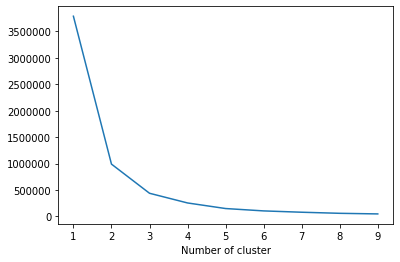

In [39]:
from sklearn.cluster import KMeans
sse={}
retail_uk_lastorder = retail_uk_customer[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(retail_uk_lastorder)
    retail_uk_lastorder['recencycluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

### Clustering recency for K=4

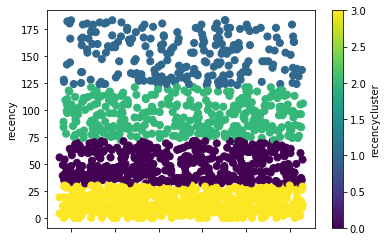

In [40]:
kmodel = KMeans(n_clusters=4)
kmodel.fit(retail_uk_customer[['recency']])
retail_uk_customer['recencycluster']=kmodel.predict(retail_uk_customer[['recency']])
#fig, axes = plt.subplots(1, 2, figsize=(16,8))
ax1=retail_uk_customer.plot.scatter(x='customerid',y='recency',c='recencycluster',colormap='viridis',s=50)

In [41]:
retail_uk_customer.groupby(['recencycluster'])[['recency']].describe()

recency                                                     \
                 count        mean        std    min    25%    50%    75%   
recencycluster                                                              
0                459.0   48.956427  12.305706   32.0   37.0   47.0   61.0   
1                214.0  150.948598  18.688757  123.0  133.0  152.5  166.0   
2                328.0   94.560976  13.989378   72.0   82.0   95.0  105.0   
3                621.0   13.901771   8.692508    0.0    6.0   13.0   21.0   

                       
                  max  
recencycluster         
0                71.0  
1               183.0  
2               121.0  
3                30.0

### Frequency

Frequency is calculated by counting the number of invoices from the customer

In [42]:
retail_uk_purchasecount=retail_uk_6mon.groupby('customerid').invoicedate.nunique().reset_index()
retail_uk_purchasecount.columns=['customerid','frequency']

#customerid 
#retail_uk_cf=pd.DataFrame(retail_uk['customerid'].unique())
#retail_uk_cf.columns=['customerid']


#purchase count by customerid

retail_uk_customer=pd.merge(retail_uk_customer,retail_uk_purchasecount,on='customerid')

In [43]:
retail_uk_customer.head()

,customerid,purchaseinterval,recency,recencycluster,frequency
0,16717.0,141,104,2,2
1,16202.0,118,89,2,4
2,13694.0,26,19,3,48
3,17241.0,66,50,0,9
4,14870.0,101,49,0,3


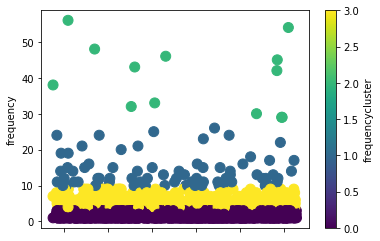

In [44]:
kmodel = KMeans(n_clusters=4)
kmodel.fit(retail_uk_customer[['frequency']])
retail_uk_customer['frequencycluster']=kmodel.predict(retail_uk_customer[['frequency']])
#fig, axes = plt.subplots(1, 2, figsize=(16,8))
ax1=retail_uk_customer.plot.scatter(x='customerid',y='frequency',c='frequencycluster',colormap='viridis',s=100)

In [45]:
retail_uk_customer.groupby(['frequencycluster'])[['frequency']].describe()

frequency                                                   
                     count       mean       std   min   25%   50%   75%   max
frequencycluster                                                             
0                   1106.0   1.713382  0.771754   1.0   1.0   2.0   2.0   3.0
1                     78.0  13.769231  4.263780  10.0  11.0  12.0  15.0  26.0
2                     13.0  40.384615  9.341114  29.0  32.0  42.0  46.0  56.0
3                    425.0   5.409412  1.530170   4.0   4.0   5.0   6.0   9.0

## Monetary

Monetary is calculated by adding all the purchase amount by the customer

In [46]:
retail_uk_cost=retail_uk_6mon.groupby('customerid')['total'].sum().reset_index()
retail_uk_cost.columns=['customerid','income']
retail_uk_cost=retail_uk_cost[retail_uk_cost['income']<10000]
retail_uk_customer=pd.merge(retail_uk_customer,retail_uk_cost,on='customerid')

In [47]:
retail_uk_customer.head()

,customerid,purchaseinterval,recency,recencycluster,frequency,frequencycluster,income
0,16717.0,141,104,2,2,0,422.89
1,16202.0,118,89,2,4,3,712.21
2,17241.0,66,50,0,9,3,1447.29
3,14870.0,101,49,0,3,0,761.10
4,17865.0,18,8,3,12,1,5878.98


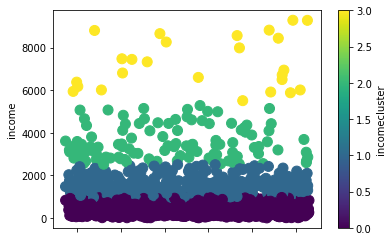

In [48]:
kmodel = KMeans(n_clusters=4)
kmodel.fit(retail_uk_customer[['income']])
retail_uk_customer['incomecluster']=kmodel.predict(retail_uk_customer[['income']])
#fig, axes = plt.subplots(1, 2, figsize=(16,8))retail_uk_customer
ax1=retail_uk_customer.plot.scatter(x='customerid',y='income',c='incomecluster',colormap='viridis',s=100)

In [49]:
retail_uk_customer.groupby(['incomecluster'])[['income']].describe()

income                                                         \
                count         mean          std      min       25%       50%   
incomecluster                                                                  
0              1096.0   414.950465   249.996546     4.25   201.870   369.165   
1               367.0  1516.792752   404.271575   968.70  1172.595  1430.090   
2               112.0  3490.740804   773.332373  2525.04  2852.795  3332.920   
3                25.0  7268.911600  1205.077788  5508.48  6175.200  6941.700   

                                   
                     75%      max  
incomecluster                      
0               599.3725   966.03  
1              1756.8000  2503.13  
2              4099.8325  5279.94  
3              8440.0500  9283.16

## Customer segmentation based on RFM

Based on Recency ,Frequency and Monetary a score is calculated.

In [50]:
retail_uk_customer['score']=retail_uk_customer['recencycluster']+retail_uk_customer['frequencycluster']+retail_uk_customer['incomecluster']
retail_uk_customer.groupby('score')['recency','frequency','income'].mean()


,recency,frequency,income
score,,,
0,51.054348,1.840580,435.750797
1,134.239669,1.376033,462.420868
2,96.128814,1.579661,413.677525
3,26.562500,2.552083,615.860243
4,33.944882,4.314961,1596.065748
5,41.947368,7.684211,2328.055263
6,24.438596,7.035088,1663.754298
7,13.349693,6.865031,2117.499264
8,11.734694,7.387755,3400.551633


## Last three purchases,mean and standard deviation between the days

Last three purchases for the customer are calculated and the  days between last invoice and the previous invoices are calculated. All customers with less than three transactions are removed as customer with atleast three trasactions can be considered frequent

In [51]:
#days between last three purchase 

retail_uk_invoice=retail_uk_6mon[['customerid','invoicedate']]
retail_uk_invoice['invoiceday']=retail_uk_invoice['invoicedate'].dt.date
retail_uk_invoice=retail_uk_invoice.sort_values(['customerid','invoicedate'])
retail_uk_invoice=retail_uk_invoice.drop_duplicates(subset=['customerid','invoicedate'])


In [52]:
retail_uk_invoice.head()

,customerid,invoicedate,invoiceday
997,12346.0,2010-03-02 13:08:00,2010-03-02
88430,12346.0,2010-06-28 13:53:00,2010-06-28
54485,12745.0,2010-05-14 16:50:00,2010-05-14
117902,12745.0,2010-08-10 10:14:00,2010-08-10
81327,12746.0,2010-06-17 10:41:00,2010-06-17


In [53]:
#fill the dataframe with three invoice date sequence

retail_uk_invoice['lastpurchase']=retail_uk_invoice.groupby('customerid')['invoiceday'].shift(1)
retail_uk_invoice['secondpurchase']=retail_uk_invoice.groupby('customerid')['invoiceday'].shift(2)
retail_uk_invoice['firstpurchase']=retail_uk_invoice.groupby('customerid')['invoiceday'].shift(3)

In [54]:
retail_uk_invoice.head(15)

,customerid,invoicedate,invoiceday,lastpurchase,secondpurchase,firstpurchase
997,12346.0,2010-03-02 13:08:00,2010-03-02,NaN,NaN,NaN
88430,12346.0,2010-06-28 13:53:00,2010-06-28,2010-03-02,NaN,NaN
54485,12745.0,2010-05-14 16:50:00,2010-05-14,NaN,NaN,NaN
117902,12745.0,2010-08-10 10:14:00,2010-08-10,2010-05-14,NaN,NaN
81327,12746.0,2010-06-17 10:41:00,2010-06-17,NaN,NaN,NaN
6819,12747.0,2010-03-09 15:16:00,2010-03-09,NaN,NaN,NaN
37903,12747.0,2010-04-23 09:51:00,2010-04-23,2010-03-09,NaN,NaN
64024,12747.0,2010-05-27 10:04:00,2010-05-27,2010-04-23,2010-03-09,NaN
77603,12747.0,2010-06-13 12:54:00,2010-06-13,2010-05-27,2010-04-23,2010-03-09
85333,12747.0,2010-06-23 14:07:00,2010-06-23,2010-06-13,2010-05-27,2010-04-23


In [55]:
#find the diff btween last invoice and first invoice,last and second invoice,last and third invoice

retail_uk_invoice['lastinterval']=(retail_uk_invoice['invoiceday']-retail_uk_invoice['lastpurchase']).dt.days
retail_uk_invoice['secondinterval']=(retail_uk_invoice['invoiceday']-retail_uk_invoice['secondpurchase']).dt.days
retail_uk_invoice['thirdinterval']=(retail_uk_invoice['invoiceday']-retail_uk_invoice['firstpurchase']).dt.days

In [56]:
retail_uk_invoice.head(10)

,customerid,invoicedate,invoiceday,lastpurchase,secondpurchase,firstpurchase,lastinterval,secondinterval,thirdinterval
997,12346.0,2010-03-02 13:08:00,2010-03-02,NaN,NaN,NaN,NaN,NaN,NaN
88430,12346.0,2010-06-28 13:53:00,2010-06-28,2010-03-02,NaN,NaN,118.0,NaN,NaN
54485,12745.0,2010-05-14 16:50:00,2010-05-14,NaN,NaN,NaN,NaN,NaN,NaN
117902,12745.0,2010-08-10 10:14:00,2010-08-10,2010-05-14,NaN,NaN,88.0,NaN,NaN
81327,12746.0,2010-06-17 10:41:00,2010-06-17,NaN,NaN,NaN,NaN,NaN,NaN
6819,12747.0,2010-03-09 15:16:00,2010-03-09,NaN,NaN,NaN,NaN,NaN,NaN
37903,12747.0,2010-04-23 09:51:00,2010-04-23,2010-03-09,NaN,NaN,45.0,NaN,NaN
64024,12747.0,2010-05-27 10:04:00,2010-05-27,2010-04-23,2010-03-09,NaN,34.0,79.0,NaN
77603,12747.0,2010-06-13 12:54:00,2010-06-13,2010-05-27,2010-04-23,2010-03-09,17.0,51.0,96.0
85333,12747.0,2010-06-23 14:07:00,2010-06-23,2010-06-13,2010-05-27,2010-04-23,10.0,27.0,61.0


In [57]:
#calculating mean and std for firstinterval

retail_uk_invoice_stat=retail_uk_invoice.groupby('customerid').agg({'lastinterval':['mean','std']}).reset_index()
retail_uk_invoice_stat.columns=['customerid','intervalmean','intervalstd']

In [58]:
# drop all invoices for the customer except the last,to make sure there are customer with more than three transaction

retail_uk_invoice_final=retail_uk_invoice.drop_duplicates(subset=['customerid'],keep='last')
retail_uk_invoice_final=retail_uk_invoice_final.dropna()
retail_uk_invoice_final=pd.merge(retail_uk_invoice_final,retail_uk_invoice_stat,on='customerid')


In [59]:
retail_uk_invoice_final.head()

,customerid,invoicedate,invoiceday,lastpurchase,secondpurchase,firstpurchase,lastinterval,secondinterval,thirdinterval,intervalmean,intervalstd
0,12747.0,2010-08-27 14:33:00,2010-08-27,2010-08-02,2010-06-23,2010-06-13,25.0,65.0,75.0,28.500000,13.575714
1,12748.0,2010-08-12 14:39:00,2010-08-12,2010-08-04,2010-08-03,2010-08-02,8.0,9.0,10.0,4.324324,3.407949
2,12823.0,2010-07-13 16:36:00,2010-07-13,2010-07-01,2010-06-03,2010-06-03,12.0,40.0,40.0,18.571429,10.737119
3,12835.0,2010-08-26 13:09:00,2010-08-26,2010-08-12,2010-08-12,2010-07-21,14.0,14.0,36.0,7.652174,5.440661
4,12836.0,2010-08-26 15:27:00,2010-08-26,2010-07-29,2010-07-29,2010-06-06,28.0,28.0,81.0,29.800000,21.229696


In [60]:
retail_uk_customer=pd.merge(retail_uk_customer,retail_uk_invoice_final[['customerid','lastinterval','secondinterval','thirdinterval','intervalmean','intervalstd']],on='customerid')

## Customer dataframe

In [61]:
retail_uk_customer.head(10)

,customerid,purchaseinterval,recency,recencycluster,frequency,frequencycluster,income,incomecluster,score,lastinterval,secondinterval,thirdinterval,intervalmean,intervalstd
0,16202.0,118,89,2,4,3,712.21,0,5,0.0,94.0,94.0,31.333333,54.270925
1,17241.0,66,50,0,9,3,1447.29,1,4,3.0,40.0,45.0,16.625000,13.968715
2,17865.0,18,8,3,12,1,5878.98,3,7,0.0,10.0,33.0,15.909091,14.208832
3,14527.0,5,0,3,32,2,5142.77,2,7,8.0,22.0,34.0,5.903226,3.467514
4,18231.0,64,36,0,17,1,2684.20,2,3,0.0,10.0,26.0,9.187500,7.314085
5,13018.0,131,105,2,5,3,1403.75,1,6,0.0,0.0,78.0,19.500000,39.000000
6,17377.0,8,0,3,30,2,4097.55,2,7,16.0,19.0,25.0,6.310345,4.993592
7,17965.0,54,48,0,6,3,1320.51,1,4,19.0,27.0,47.0,27.000000,26.143833
8,17324.0,45,43,0,5,3,571.55,0,3,75.0,75.0,89.0,35.000000,34.263683
9,14401.0,47,6,3,5,3,1227.22,1,7,21.0,61.0,121.0,44.250000,17.745892


### Customer Segmentation based on upcoming purchase

Creating three categorical varibales based on business condition .Upcoming purchases in 3 weeks as Group :2,upcoming purchases in 4-7 weeks as Group:1 ,purchases beyond 7 weeks group :0

In [62]:
retail_uk_customer.head()

,customerid,purchaseinterval,recency,recencycluster,frequency,frequencycluster,income,incomecluster,score,lastinterval,secondinterval,thirdinterval,intervalmean,intervalstd
0,16202.0,118,89,2,4,3,712.21,0,5,0.0,94.0,94.0,31.333333,54.270925
1,17241.0,66,50,0,9,3,1447.29,1,4,3.0,40.0,45.0,16.625000,13.968715
2,17865.0,18,8,3,12,1,5878.98,3,7,0.0,10.0,33.0,15.909091,14.208832
3,14527.0,5,0,3,32,2,5142.77,2,7,8.0,22.0,34.0,5.903226,3.467514
4,18231.0,64,36,0,17,1,2684.20,2,3,0.0,10.0,26.0,9.187500,7.314085


In [63]:
# Create encoding customer dataframe with get dummies and categorical variables for customer groups

retail_uk_customer_enc = retail_uk_customer.copy()
retail_uk_customer_enc = pd.get_dummies(retail_uk_customer_enc)

retail_uk_customer_enc['customersegment'] =2
retail_uk_customer_enc.loc[retail_uk_customer_enc.purchaseinterval>20,'customersegment'] = 1
retail_uk_customer_enc.loc[retail_uk_customer_enc.purchaseinterval>50,'customersegment'] = 0

In [64]:
retail_uk_customer_enc.head()

,customerid,purchaseinterval,recency,recencycluster,frequency,frequencycluster,income,incomecluster,score,lastinterval,secondinterval,thirdinterval,intervalmean,intervalstd,customersegment
0,16202.0,118,89,2,4,3,712.21,0,5,0.0,94.0,94.0,31.333333,54.270925,0
1,17241.0,66,50,0,9,3,1447.29,1,4,3.0,40.0,45.0,16.625000,13.968715,0
2,17865.0,18,8,3,12,1,5878.98,3,7,0.0,10.0,33.0,15.909091,14.208832,2
3,14527.0,5,0,3,32,2,5142.77,2,7,8.0,22.0,34.0,5.903226,3.467514,2
4,18231.0,64,36,0,17,1,2684.20,2,3,0.0,10.0,26.0,9.187500,7.314085,0


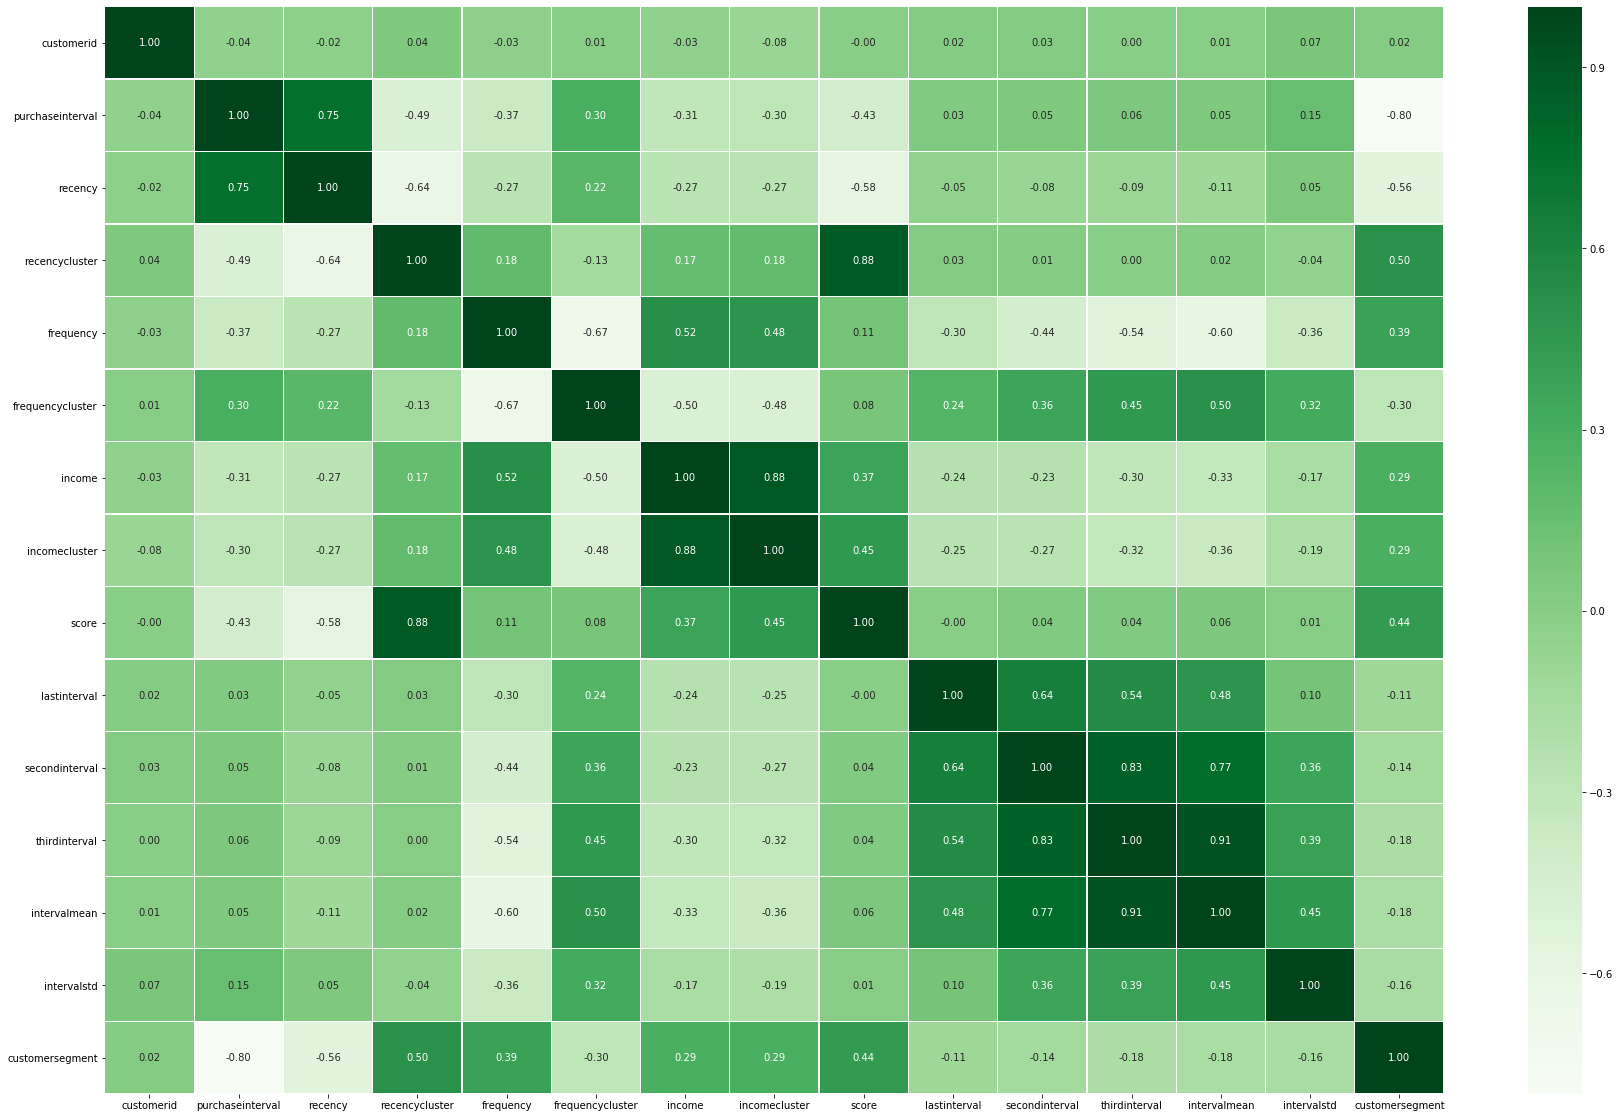

In [65]:
corr = retail_uk_customer_enc[retail_uk_customer_enc.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt='.2f',cmap='Greens')

## Modelling  and Cross Validation

In [66]:
# creating test and train

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

retail_uk_customer_enc=retail_uk_customer_enc.drop(['purchaseinterval'],axis=1)
X=retail_uk_customer_enc.drop('customersegment',axis=1)
y=retail_uk_customer_enc.customersegment
#Y=retail_uk_customer_enc[['customersegment']]   


#X_train, X_test, y_train, y_test = train_test_split(retail_uk_customer_enc.drop('customersegment',axis=1),retail_uk_customer_enc['customersegment'], test_size=0.30,random_state=101)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
models = []

models.append(("LR",LogisticRegression()))
models.append(("RF",RandomForestClassifier()))
models.append(("Dtree",DecisionTreeClassifier()))



for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.57803468 0.6416185 ]
RF [0.6416185  0.57225434]
Dtree [0.52023121 0.5433526 ]


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[58 13  3]
 [23 29  4]
 [ 1  9  9]]


In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74        74
           1       0.57      0.52      0.54        56
           2       0.56      0.47      0.51        19

    accuracy                           0.64       149
   macro avg       0.61      0.59      0.60       149
weighted avg       0.64      0.64      0.64       149



In [70]:
#y_test['customersegment']=y_pred
y_pred_df = pd.DataFrame(data = y_pred, columns = ['customersegment'], index = X_test.index.copy())
retail_uk_prediction = pd.merge(X_test,y_test,left_index = True, right_index = True)

In [71]:
retail_uk_prediction.head(10)

,customerid,recency,recencycluster,frequency,frequencycluster,income,incomecluster,score,lastinterval,secondinterval,thirdinterval,intervalmean,intervalstd,customersegment
88,14852.0,12,3,9,3,2139.92,1,7,0.0,34.0,34.0,20.875000,23.715200,1
396,17888.0,21,3,8,3,487.92,0,6,49.0,62.0,67.0,16.714286,16.839579,1
345,13856.0,29,3,7,3,554.00,0,6,38.0,54.0,71.0,20.833333,9.537645,1
300,13969.0,18,3,9,3,1548.64,1,7,14.0,21.0,36.0,17.500000,13.212548,1
115,16013.0,35,0,12,1,2817.97,2,3,0.0,14.0,62.0,12.818182,15.335046,1
161,13659.0,27,3,8,3,2198.01,1,7,34.0,51.0,76.0,20.857143,12.019825,0
269,14040.0,0,3,12,1,3350.24,2,6,0.0,25.0,42.0,14.727273,8.989893,2
253,16905.0,32,0,4,3,298.61,0,3,102.0,102.0,133.0,44.333333,52.290853,0
463,17442.0,2,3,6,3,1185.39,1,7,26.0,33.0,34.0,20.800000,29.422780,1
49,16636.0,117,2,4,3,2167.09,1,6,48.0,64.0,64.0,21.333333,24.440404,0


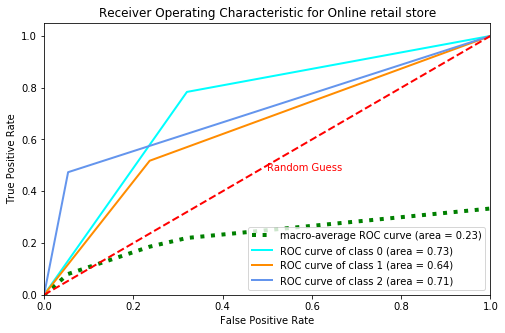

In [72]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle

y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Online retail store')
plt.legend(loc="lower right")
plt.show()